<a href="https://colab.research.google.com/github/LichtEwig/Machine-Learning/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTAR LIBRERÍAS Y DATASETS


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
import plotly.graph_objects as go
import nbformat
from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline


In [2]:
# Necesitamos montar el disco usando los siguientes comandos:
# Para obtener más información sobre el montaje, puedes consultar: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Navegamos hasta el directorio My Drive para almacenar el conjunto de datos y herramientas adicionales
%cd /content/drive/My Drive/TP-Final-PJML-II

/content/drive/My Drive/TP-Final-PJML-II


In [4]:
# Datos que contienen la ruta a Brain MRI y su máscara correspondiente
brain_df = pd.read_csv('dataset/data_mask.csv')

In [5]:
# Obtener la ruta absoluta de la carpeta "dataset"
dataset_folder = os.path.abspath('dataset')

# Listas para almacenar las rutas de imágenes y las máscaras
image_paths = []
mask_paths = []

# Construir las rutas de imágenes y máscaras para todas las posiciones
for index in range(len(brain_df)):
    image_path = os.path.join(dataset_folder, brain_df.image_path[index])
    mask_path = os.path.join(dataset_folder, brain_df.mask_path[index])
    image_paths.append(image_path)
    mask_paths.append(mask_path)

# Ahora image_paths y mask_paths contienen las rutas de imágenes y máscaras para todas las posiciones
print(image_paths)
print(mask_paths)

['/content/drive/My Drive/TP-Final-PJML-II/dataset/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif', '/content/drive/My Drive/TP-Final-PJML-II/dataset/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif', '/content/drive/My Drive/TP-Final-PJML-II/dataset/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif', '/content/drive/My Drive/TP-Final-PJML-II/dataset/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif', '/content/drive/My Drive/TP-Final-PJML-II/dataset/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif', '/content/drive/My Drive/TP-Final-PJML-II/dataset/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif', '/content/drive/My Drive/TP-Final-PJML-II/dataset/TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif', '/content/drive/My Drive/TP-Final-PJML-II/dataset/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif', '/content/drive/My Drive/TP-Final-PJML-II/dataset/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif', '/content/drive/My Drive/TP-Final-PJML-II/dataset/TCGA_CS_6666_20011109/TCGA_CS_6

In [6]:
# Obtenemos la información de los datos
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [7]:
# Obtenemos los encabezados y los datos de los primeros 50 registros
brain_df.head(50)

patient_id                                         image_path  \
0   TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1   TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2   TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3   TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4   TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
5   TCGA_CS_5395_19981004  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif   
6   TCGA_CS_5395_19981004  TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif   
7   TCGA_CS_5395_19981004  TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif   
8   TCGA_CS_5395_19981004  TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif   
9   TCGA_CS_5395_19981004  TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif   
10  TCGA_CS_5395_19981004  TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_1.tif   
11  TCGA_CS_5395_19981004  TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_1.tif   
12  TCGA_CS_5395_19981004  TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_1.tif   
13  TCGA_CS_5395_19981004  TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_1.tif   
14  TCGA_CS_5395_19981004  TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_1.tif   
15  TCGA_CS_5395_19981004  TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_1.tif   
16  TCGA_CS_5395_19981004  TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_1.tif   
17  TCGA_CS_5395_19981004  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_1.tif   
18  TCGA_CS_5395_19981004  TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_1.tif   
19  TCGA_CS_5395_19981004  TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_1.tif   
20  TCGA_CS_4944_20010208  TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1.tif   
21  TCGA_CS_4944_20010208  TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1.tif   
22  TCGA_CS_4944_20010208  TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1.tif   
23  TCGA_CS_4944_20010208  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_1.tif   
24  TCGA_CS_4944_20010208  TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1.tif   
25  TCGA_CS_4944_20010208  TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_1.tif   
26  TCGA_CS_4944_20010208  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_1.tif   
27  TCGA_CS_4944_20010208  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1.tif   
28  TCGA_CS_4944_20010208  TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_1.tif   
29  TCGA_CS_4944_20010208  TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1.tif   
30  TCGA_CS_4944_20010208  TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_1.tif   
31  TCGA_CS_4944_20010208  TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_1.tif   
32  TCGA_CS_4944_20010208  TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_1.tif   
33  TCGA_CS_4944_20010208  TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_1.tif   
34  TCGA_CS_4944_20010208  TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_1.tif   
35  TCGA_CS_4944_20010208  TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_1.tif   
36  TCGA_CS_4944_20010208  TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_1.tif   
37  TCGA_CS_4944_20010208  TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_1.tif   
38  TCGA_CS_4944_20010208  TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif   
39  TCGA_CS_4944_20010208  TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif   
40  TCGA_CS_4941_19960909  TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_1.tif   
41  TCGA_CS_4941_19960909  TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_1.tif   
42  TCGA_CS_4941_19960909  TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_1.tif   
43  TCGA_CS_4941_19960909  TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif   
44  TCGA_CS_4941_19960909  TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_1.tif   
45  TCGA_CS_4941_19960909  TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_1.tif   
46  TCGA_CS_4941_19960909  TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_1.tif   
47  TCGA_CS_4941_19960909  TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_1.tif   
48  TCGA_CS_4941_19960909  TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_1.tif   
49  TCGA_CS_494

In [8]:
# Ruta a la imagen de la MRI en la posición [1]
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [9]:
# Ruta a la máscara de segmentación en la posición [1]
brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [10]:
# Obtenemos la cantidad de pacientes con y sin tumores
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

# VISUALIZACIÓN DE DATOS


In [11]:
# Visualizamos todos los datos

brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

In [12]:
# Visualizamos los diversos valores que posee la máscara. Para este caso en particular, es un tipo binario donde  0 = No presenta tumores, 1 = Presenta tumores

brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [13]:
# Usamos plotly para hacer un diagrama de barras interactivo con la distribución de los datos

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [14]:
# Obtenemos el path de cada mascara de cada imagen
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [15]:
# Obtenemos el path de cada imagen original
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

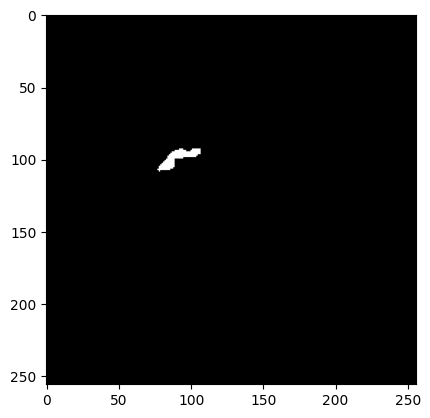

In [16]:
# visualizamos una imagen de tipo máscara en una determinada posición para visualizar el tumor.
plt.imshow(cv2.imread(mask_paths[623]))

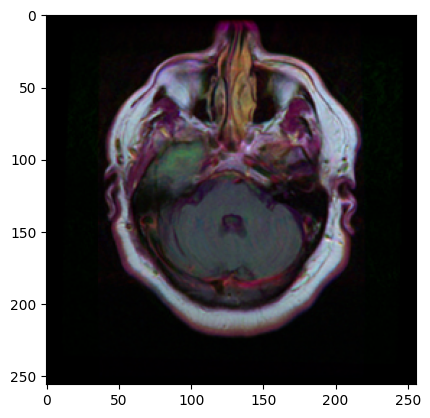

In [17]:
# visualizamos una imagen en una determinada posición para visualizar sin la máscara.
plt.imshow(cv2.imread(image_paths[623]))

In [18]:
# obtenemos el máximo valor de píxel de la imagen
cv2.imread(mask_paths[623]).max()

255

In [19]:
# obtenemos el mínimo valor de píxel de la imagen
cv2.imread(mask_paths[623]).min()

0

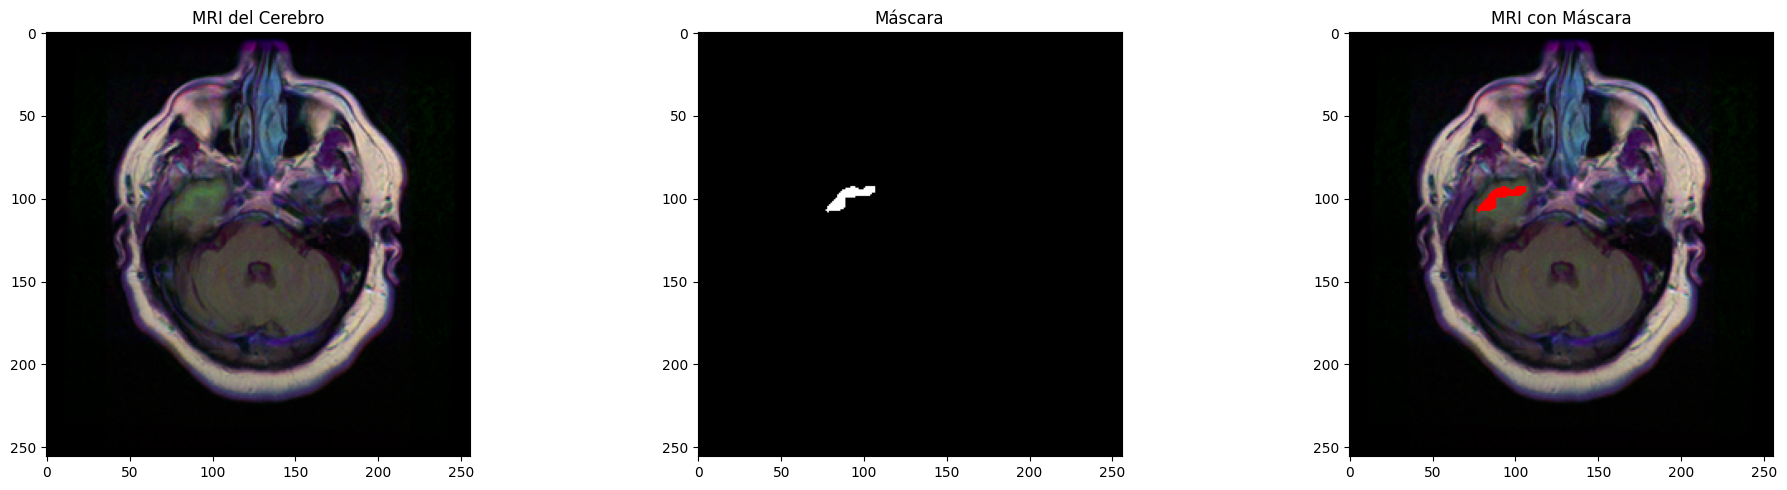

In [20]:
# Visualizamos la resonancia magnética, la máscara, y ambas de manera superpuesta
# Posición del DATASET
i = 623

if brain_df['mask'][i] == 1:
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))  # Solo una fila con tres columnas

    img = io.imread(image_paths[i])
    axs[0].title.set_text('MRI del Cerebro')
    axs[0].imshow(img)

    mask = io.imread(mask_paths[i])
    axs[1].title.set_text('Máscara')
    axs[1].imshow(mask, cmap='gray')

    img[mask == 255] = (255, 0, 0)
    axs[2].title.set_text('MRI con Máscara')
    axs[2].imshow(img)

    plt.tight_layout()
    plt.show()

# Representamos 6 imágenes de MRI seleccionadas aleatoriamente de entre los pacientes seguidas de su correspondiente máscara.


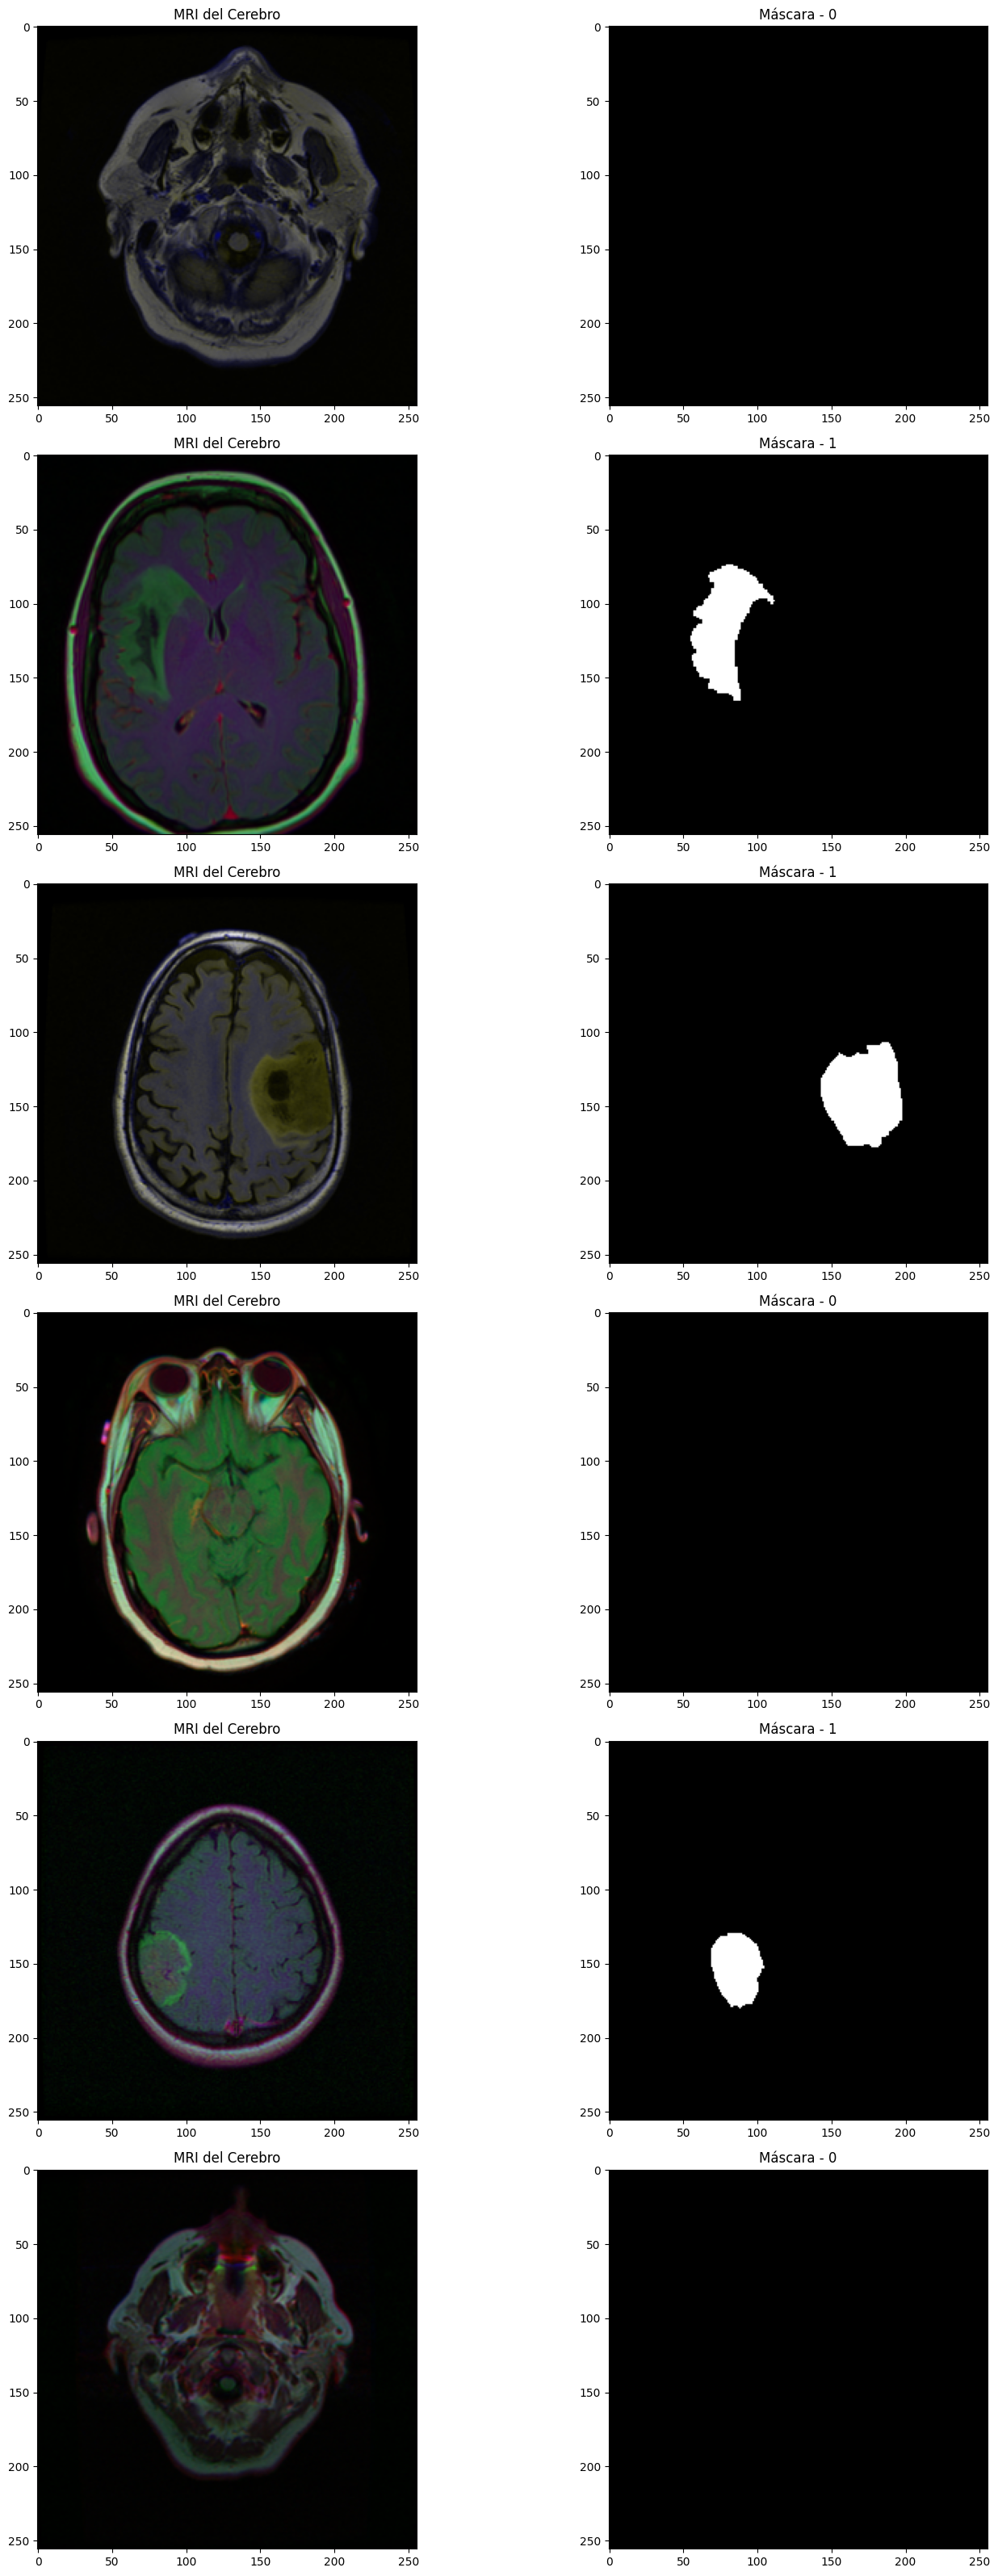

In [21]:
# Visualización básica de imágenes (MRI y Máscaras) en el dataset de forma separada de manera aleatoria
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # Seleccionamos un índice aleatorio
  axs[count][0].title.set_text("MRI del Cerebro") # Configuramos el título
  axs[count][0].imshow(cv2.imread(image_paths[i])) # Mostramos la MRI
  axs[count][1].title.set_text("Máscara - " + str(brain_df['mask'][i])) # Colocámos el título en la máscara (0 o 1)
  axs[count][1].imshow(cv2.imread(mask_paths[i])) # Mostramos la máscara correspondiente
  count += 1

fig.tight_layout()

# Representamos 12 imágenes de MRI seleccionadas aleatoriamente de entre los pacientes enfermos seguidas de su correspondiente máscara, tanto la imágen de la MRI junto con su máscara (de color rojo) una encima de la otra.


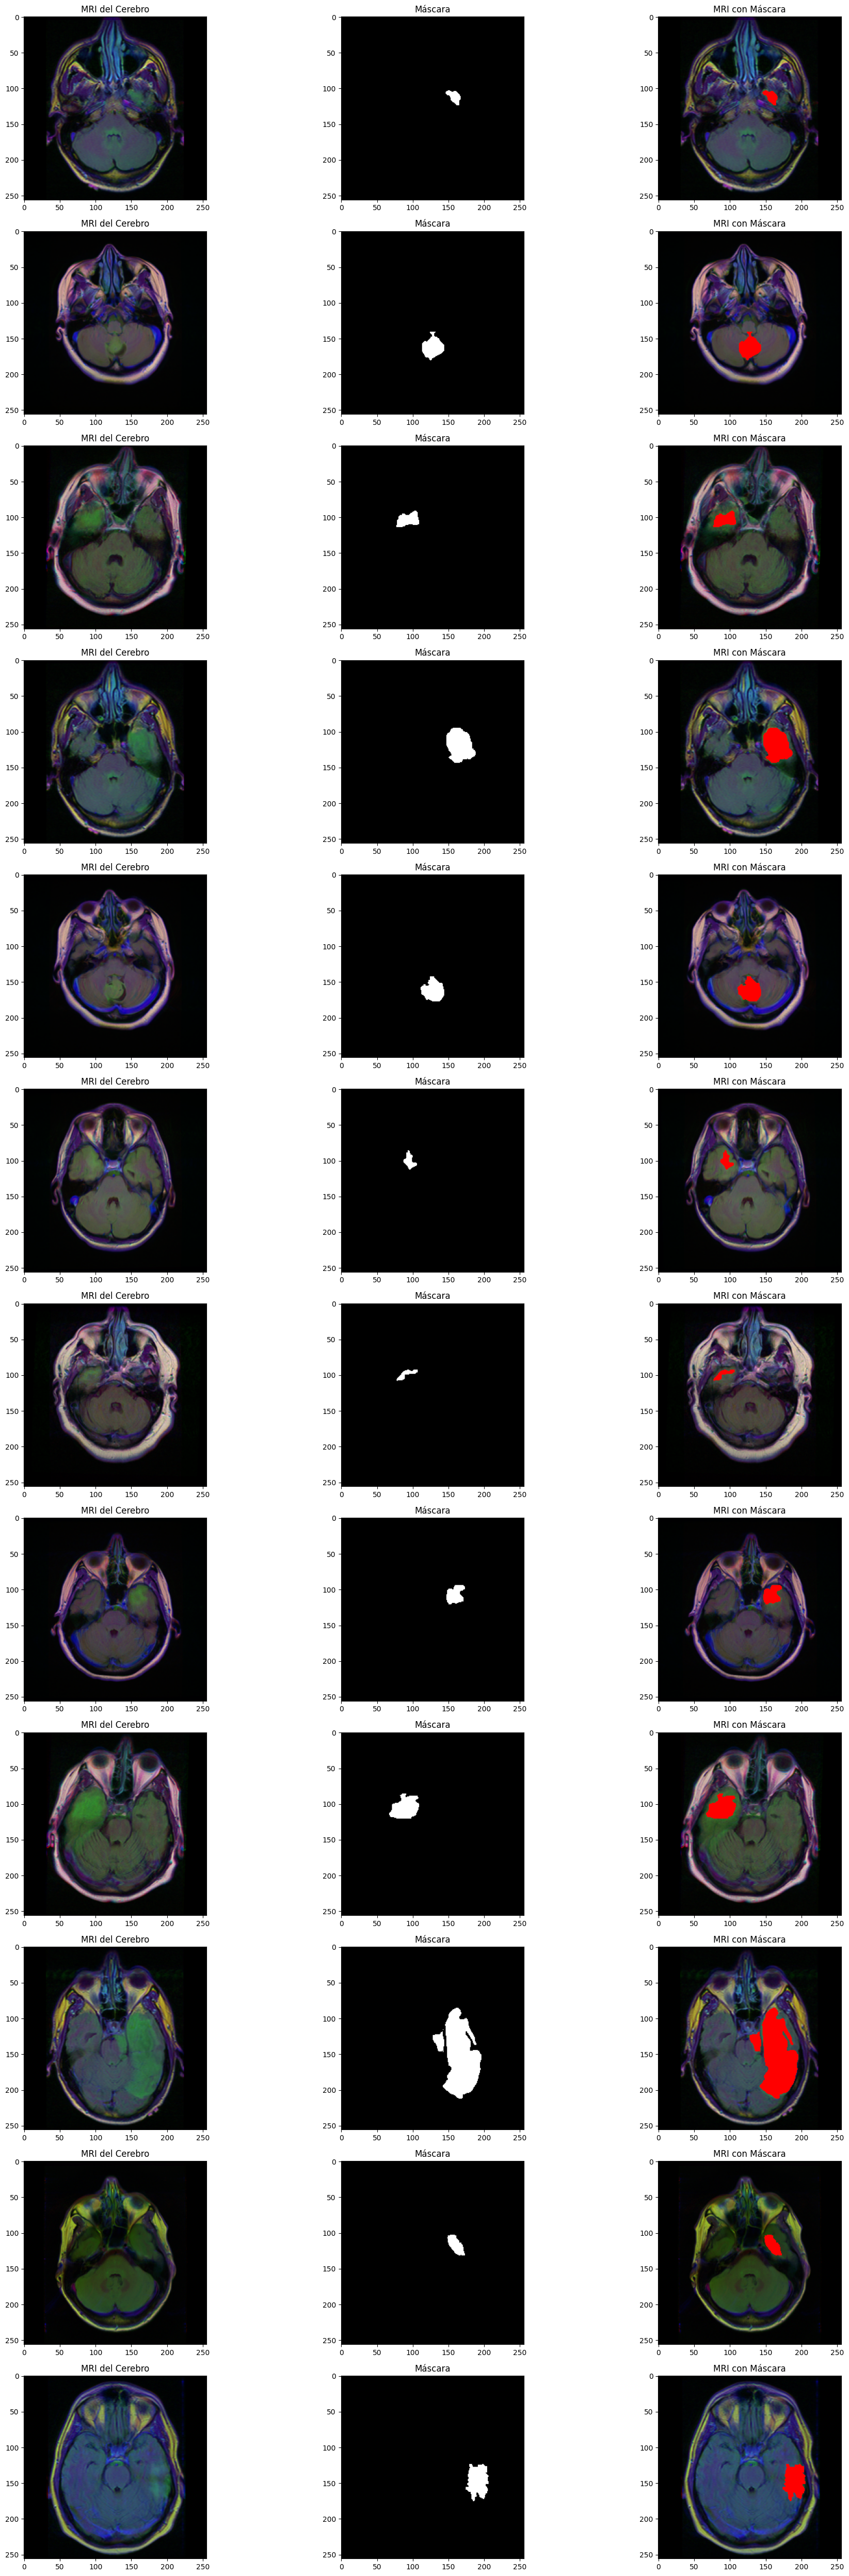

In [22]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(image_paths[i])
    axs[count][0].title.set_text('MRI del Cerebro')
    axs[count][0].imshow(img)

    mask = io.imread(mask_paths[i])
    axs[count][1].title.set_text('Máscara')
    axs[count][1].imshow(mask, cmap = 'gray')


    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI con Máscara')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()


# ENTRENAMOS UN MODELO CLASIFICADOR PARA DETECTAR SI EXISTE TUMOR O NO


In [23]:
# Visualizamos que tenemos cuatro columnas
brain_df.shape

(3929, 4)

In [24]:
# Eliminamos la columna de identificador del paciente
brain_df_train = brain_df.drop(columns = ['patient_id'])

In [25]:
# Visualizamos que tenemos solo tres columnas ahora
brain_df_train.shape

(3929, 3)

In [26]:
# Obtenemos la información del dataframe
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


In [27]:
# Convertir los datos en la columna de máscara a formato de string, para usar el modo categórico

brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

# Verás este mensaje de error si no se ejecuta el código
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.

In [28]:
# Obtenemos nuevamente la información del dataframe
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [29]:
# Dividimos los datos para el entrenamiento y testing dejando un 15% para testeos y 85% para entrenamiento
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [30]:
# Creamos el generador de imágenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creamos un generador de datos que escale los datos de 0 a 1 y haga una división de validación de 15% para la validación cruzada
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [31]:
# Creamos un generador de datos para el entrenamiento

train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './dataset/',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Creamos un generador de datos para la validación

valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './dataset/',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Creamos un generador de datos para imágenes de prueba

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './dataset/',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [32]:
# Obtenemos el modelo base de ResNet50 (red neuronal entrenada) sin la capa densa para predecir las categorías, para aplicar al caso de uso.
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 5s 0us/step


In [33]:
# Obtenemos el resumen del modelo base con el detalle de parámetros
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [34]:
# Congelamos los pesos del modelo base

for layer in basemodel.layers:
  layers.trainable = False

In [35]:
# Agregamos una cabecera de clasificación al modelo base

headmodel = basemodel.output
# Reducimos el tamaño de la imagen a 2 x 2
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
# Aplanamos para obtener una red neuronal una detras de la otra de 2 x 2 x 2048
headmodel = Flatten(name= 'flatten')(headmodel)
# Aplicamos una capa densa para reducir el tamaño y que utiliza el metodo de Acivacion Rectificador lineal unitario
headmodel = Dense(256, activation = "relu")(headmodel)
# Agregamos una capa dropout para mejorar la capacidad de generalización del modelo
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
# Al final del modelo se aplica una capa con dos posibilidades y con funcion de activación de tipo entropía.
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [36]:
# Visualizamos los parámetros del modelo

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [37]:
# # Compilamos el modelo
# Se utiliza el gradiente descendiente estocástico adaptado llamado "adam"
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [38]:
# # Utilizamos la parada temprana para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# # Guardamos el mejor modelo con la menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [39]:
# Generamos el entrenamiento
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

177/177 [==============================] - ETA: 0s - loss: 0.8433 - accuracy: 0.6978
Epoch 1: val_loss improved from inf to 4.60429, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 2066s 11s/step - loss: 0.8433 - accuracy: 0.6978 - val_loss: 4.6043 - val_accuracy: 0.3528


In [40]:
# Guardamos la arquitectura del modelo entrenado en un archivo json
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [41]:
# Cambiamos la arquitectura de la red agregando una capa y un Dropouts más a fin de mejorar el rendimiento

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
# Agregamos una capa más de 256 con la misma rectificadora lineal unitaria
headmodel = Dense(256, activation = "relu")(headmodel)
# Agregamos una capa más de Dropout con el mismo valor
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

# Este procedimiento permite generar una nueva versión del modelo.

In [42]:
# Visualizamos los nuevos parámetros del modelo

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

# Una vez realizado esto volvemos a entrenar el modelo con los nuevos parámetros establecidos y logramos una mejora significativa


In [43]:
# volvemos a compilar el modelo

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [44]:
# Volvemos a generar la parada temprana y guardamos el mejor modelo con la menor pérdida de validaci

# Utilizamos la parada temprana para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Guardamos el mejor modelo con la menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [45]:
# Generamos de nuevo el entrenamiento con los nuevos parámetros agregados
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 3, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/3
177/177 [==============================] - ETA: 0s - loss: 0.6113 - accuracy: 0.6978
Epoch 1: val_loss improved from inf to 50.04782, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 102s 314ms/step - loss: 0.6113 - accuracy: 0.6978 - val_loss: 50.0478 - val_accuracy: 0.6492
Epoch 2/3
177/177 [==============================] - ETA: 0s - loss: 0.4842 - accuracy: 0.7464
Epoch 2: val_loss improved from 50.04782 to 0.67803, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 51s 289ms/step - loss: 0.4842 - accuracy: 0.7464 - val_loss: 0.6780 - val_accuracy: 0.6472
Epoch 3/3
177/177 [==============================] - ETA: 0s - loss: 0.4979 - accuracy: 0.7605
Epoch 3: val_loss did not improve from 0.67803
177/177 [==============================] - 42s 238ms/step - loss: 0.4979 - accuracy: 0.7605 - val_loss: 2.9002 - val_accuracy: 0.2480


In [46]:
# Guardamos la arquitectura del modelo entrenado en un archivo json "classifier-resnet-model.json"

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

# EVALUAMOS EL RENDIMIENTO DEL MODELO ENTRENADO


In [47]:
# Cargamos el modelo pre entrenado generado en el JSON “resnet-50-MRI.json”  (MEJOR MODELO ENTRENADO GUARDADO)

#with open('resnet-50-MRI.json', 'r') as json_file:
#    json_savedModel= json_file.read()

# Cargamos el modelo entrenado generado en el JSON “classifier-resnet-model.json”  (MODELO ENTRENADO)

with open('classifier-resnet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)

# Cargamos los pesos del modelo pre entrenado generado en el JSON “weights.hdf5” (MEJOR PESO ENTRENADO GUARDADO)
#model.load_weights('weights.hdf5')

# Cargamos los pesos del modelo entrenado generado en el JSON "classifier-resnet-weights.hdf5” (PESO ENTRENADO)
model.load_weights('classifier-resnet-weights.hdf5')

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [48]:
# Hacemos la predicción. Esta se realiza sobre el 15% de imágenes que se dejaron para testeos, no con las que se usaron para entrenar. Las peticiones las realizamos en lotes de 16 imágenes cada uno.

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 361s 10s/step


In [49]:
# De las imagenes chequeamos que sean dos salidas (tiene o no tiene tumor)

test_predict.shape

(576, 2)

In [50]:
# Visualizamos un array con la probabilidad de que no contenga tumor en la primera columna y la probabilidad de que tenga en la segunda. Para cada imagen se genera un array con los dos valores

test_predict

array([[0.52259934, 0.47740063],
       [0.5257719 , 0.47422808],
       [0.5253371 , 0.4746629 ],
       ...,
       [0.52644974, 0.47355023],
       [0.5265055 , 0.47349456],
       [0.5261327 , 0.47386727]], dtype=float32)

In [51]:
# Obtenemos la clase predicha a partir del modelo
# con argmax podemos ver la probabilidad máxima de cada fila, donde si en la posición 0 indica que probablemente no contenga un tumor, la posición 1 que si lo contenga.

predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [52]:
# Ahora visualizamos el array con los valores de probabilidad

predict

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0

In [53]:
# Dado que usamos el generador de prueba, se limita el número de imágenes a leer (predecir), debido al tamaño del lote

original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [54]:
# Una vez realizado esto, podemos obtener la tasa de acierto del modelo con el set de datos de testeos

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.6770833333333334

<Axes: >

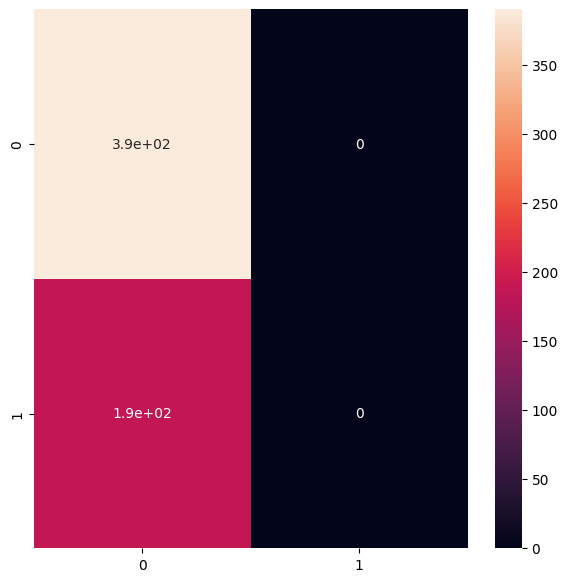

In [55]:
# La red neuronal tiene un porcentaje de efectividad del % sin aplicar la matriz de confusión.

# Representamos la matriz de confusión que nos permite identificar los falsos positivos y falsos negativos

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [56]:
# Con esto podemos ver que 3 muestras dieron un falso positivo, y 5 muestras dieron un falso negativo. Dando un total de 8 muestras erróneas
# Imprimimos el informe de clasificación y comenta sobre los resultados de precisión, recuperación y F1-Score (media entre la precisión y recall)

from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       390
           1       0.00      0.00      0.00       186

   micro avg       0.68      0.68      0.68       576
   macro avg       0.34      0.50      0.40       576
weighted avg       0.46      0.68      0.55       576



/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and